# The grand canonical ensemble


Given $H$, $P(\infty)$ and $\mu$, calculate
$$
    P(\beta) \approx \Omega(\beta)^{\dagger}\Omega(\beta),
$$
where
$$
    \Omega(\beta) = \exp(-\beta \mathcal{H}_{>}/2) \left( I - \frac{1}{2} \exp(-\beta \mathcal{H}_{>}) 
    \right) ( I - P(\infty))
    + 
    \left( I - \frac{1}{2} \exp(\beta\mathcal{H}_{<}) 
    \right) P(\infty),
$$
$$
    \mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}, \qquad 
    \mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}.
$$

In [1]:
from scipy.io import mmread
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, expm

In [2]:
beta = 10

Load matrices in nonorthogonal basis

In [3]:
%ls si

Si108_H.mtx      Si216_H.mtx      Si32_H.mtx       Si64_H.mtx
Si108_S.mtx      Si216_S.mtx      Si32_S.mtx       Si64_S.mtx
Si108_meta.yaml  Si216_meta.yaml  Si32_meta.yaml   Si64_meta.yaml


In [4]:
matrices_path = "si/"
nono_H = mmread(matrices_path + "Si216_H.mtx")
S = mmread(matrices_path + "Si216_S.mtx")

Orthogonalize the loaded Hamiltonian to get $H$

In [5]:
def funm_herm(a, func):
    w, v = eigh(a)
    w = func(w)
    return (v * w) @ v.conj().T

isq = funm_herm(S.toarray(), lambda x: -1/np.sqrt(x))

H = isq @ nono_H @ isq

Set chemical potential $\mu$ at half-filling

In [6]:
E = eigh(H, eigvals_only=True)
nel = E.size
mu = E[int(nel/2)-1] + 0.5*(E[int(nel/2)] - E[int(nel/2)-1])

The exact Fermi-Dirac distribution

In [7]:
FD_exact = np.exp(-beta * (E - mu)) / (1 + np.exp(-beta * (E - mu)))

Get the zero temperature state 

In [8]:
P_infty = funm_herm(H, lambda x: (x < mu))

In [9]:
assert np.allclose(P_infty, P_infty @ P_infty), "P_infty is not a projector!"

In [10]:
I = np.eye(H.shape[0])

Get $\mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}$ and its matrix exponent

In [11]:
def anticommut(a, b):
    return a @ b + b @ a

H_larger = 0.5 * anticommut(H - mu * I, I - P_infty)

exp_half_H_larger = expm(-0.5 * beta * H_larger)

Get $\mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}$ and its matrix exponent

In [12]:
H_less = 0.5 * anticommut(H - mu * I, P_infty)
exp_H_less = expm(beta * H_less)

In [13]:
Omega = exp_half_H_larger @ (I - 0.5 * exp_half_H_larger @ exp_half_H_larger) @ (I - P_infty)
Omega += (I - 0.5 * exp_H_less) @ P_infty

P_approx = Omega.conj().T @ Omega

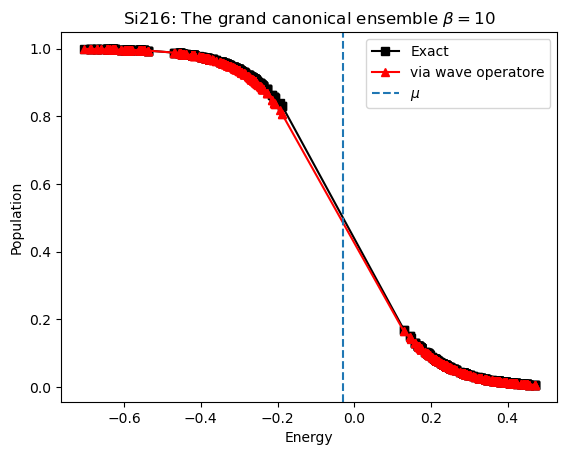

In [15]:
plt.title(f"Si216: The grand canonical ensemble $\\beta = {beta}$")

plt.plot(E, FD_exact, 'ks-', label="Exact")
plt.plot(
    E,
    eigh(P_approx, eigvals_only=True)[::-1],
    'r^-',
    label="via wave operatore"
)
plt.axvline(mu, linestyle='--', label="$\mu$")

plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig("results_si_beta=10.png")
plt.show()